In [1]:
import numpy as np
import torch
from src import get_args

CFG_FILE = 'cfgs/default.yml'
task_info = get_args(CFG_FILE)

In [2]:
from src import DataSet
Data_manager = DataSet(paths=task_info['DATA_PATH'])
data_train = Data_manager.train[:, 1:]
data_val = Data_manager.val[:, 1:]

[INFO] Data:
train: 105105 points
val: 45045
test: 13860
Header: ['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'units_sold']


In [3]:
weeks = Data_manager.data_merged[:, 1]
store_ids = Data_manager.data_merged[:, 2]
sku_ids = Data_manager.data_merged[:, 3]
unq_weeks = np.unique(weeks, return_counts=True)
unq_store_ids = np.unique(store_ids, return_counts=True)
unq_sku_ids = np.unique(sku_ids, return_counts=True)
print(f'Dates to encode: {unq_weeks[0].shape}')
print(f'Store ids to encode: {unq_store_ids[0].shape}')
print(f'Item ids to encode: {unq_sku_ids[0].shape}')
unq_weeks

Dates to encode: (130,)
Store ids to encode: (76,)
Item ids to encode: (28,)


(array(['01/01/13', '01/05/12', '01/08/11', '02/01/12', '02/04/13',
        '02/05/11', '02/07/13', '02/10/12', '03/04/12', '03/07/12',
        '03/10/11', '04/04/11', '04/06/13', '04/07/11', '04/09/12',
        '04/12/12', '05/02/13', '05/03/13', '05/06/12', '05/09/11',
        '05/12/11', '06/02/12', '06/03/12', '06/06/11', '06/11/12',
        '07/02/11', '07/03/11', '07/05/13', '07/08/12', '07/11/11',
        '08/01/13', '08/05/12', '08/08/11', '09/01/12', '09/04/13',
        '09/05/11', '09/07/13', '09/10/12', '10/04/12', '10/07/12',
        '10/10/11', '11/04/11', '11/06/13', '11/07/11', '11/09/12',
        '11/12/12', '12/02/13', '12/03/13', '12/06/12', '12/09/11',
        '12/12/11', '13/02/12', '13/03/12', '13/06/11', '13/11/12',
        '14/02/11', '14/03/11', '14/05/13', '14/08/12', '14/11/11',
        '15/01/13', '15/05/12', '15/08/11', '16/01/12', '16/04/13',
        '16/05/11', '16/10/12', '17/01/11', '17/04/12', '17/07/12',
        '17/10/11', '18/04/11', '18/06/13', '18/

In [4]:
d_unsh = Data_manager.data_unshuffled
week_data = {'11': np.zeros((13, 32)), '12': np.zeros((13, 32)), '13': np.zeros((13, 32))}
for row in d_unsh:
    week_data[row[1][-2:]][int(row[1].split('/')[1])][int(row[1].split('/')[0])] += row[-1]

In [5]:
s = np.sum(week_data['11']) + np.sum(week_data['12']) + np.sum(week_data['13'])
monthly = {'11': np.sum(week_data['11'], axis=1)[1:],
           '12': np.sum(week_data['12'], axis=1)[1:],
           '13': np.sum(week_data['13'], axis=1)[1:]}
monthly['13'] = np.where(monthly['13'] == 0, np.nan, monthly['13'])
monthly

{'11': array([168248., 331002., 232101., 207802., 307252., 232109., 218148.,
        301846., 205348., 296717., 243219., 287593.]),
 '12': array([301982., 235313., 233621., 211379., 365665., 233042., 268851.,
        234240., 210041., 293104., 221032., 263616.]),
 '13': array([274313., 271870., 230327., 274227., 246744., 228374., 129756.,
            nan,     nan,     nan,     nan,     nan])}

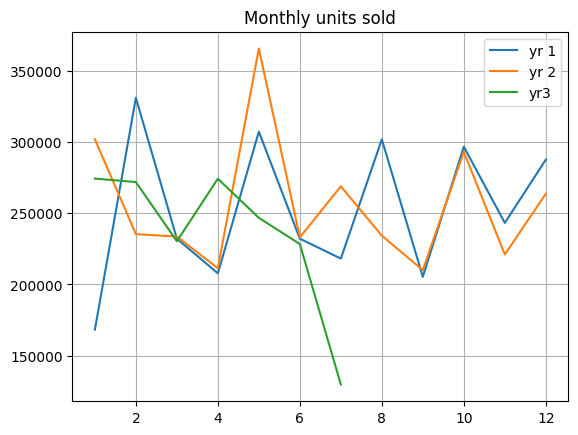

In [6]:
import matplotlib.pyplot as plt
mts = list(range(1, 13))
plt.plot(mts, monthly['11'], label='yr 1')
plt.plot(mts, monthly['12'], label='yr 2')
plt.plot(mts, monthly['13'], label='yr3')
plt.title('Monthly units sold')
plt.legend()
plt.grid()
plt.show()

In [7]:
items = [x[3] for x in d_unsh]
items = list(set(items))
item_week = {}
for item in items:
    item_week[item] = np.zeros((13, 32))

for row in d_unsh:
    item_week[row[3]][int(row[1].split('/')[1])][int(row[1].split('/')[0])] += row[-1]

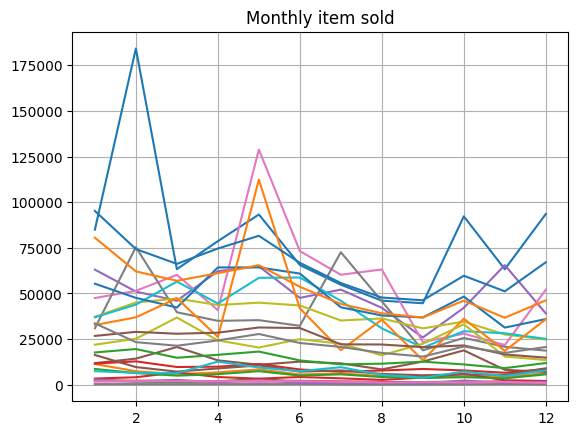

In [8]:
for key in item_week.keys():
    item_week[key] = np.sum(item_week[key], axis=1)[1:]

for key in item_week.keys():
    plt.plot(mts, item_week[key])

plt.title('Monthly item sold')
plt.grid()
plt.show()

In [9]:
items = [x[3] for x in d_unsh]
items = list(set(items))
item_week = {}
for item in items:
    item_week[item] = np.zeros((3, 13, 32))

for row in d_unsh:
    year = int(row[1].split('/')[2]) - 11
    item_week[row[3]][year][int(row[1].split('/')[1])][int(row[1].split('/')[0])] += row[-1]

In [10]:
for key in item_week.keys():
    item_week[key] = np.sum(item_week[key], axis=2)[:, 1:]

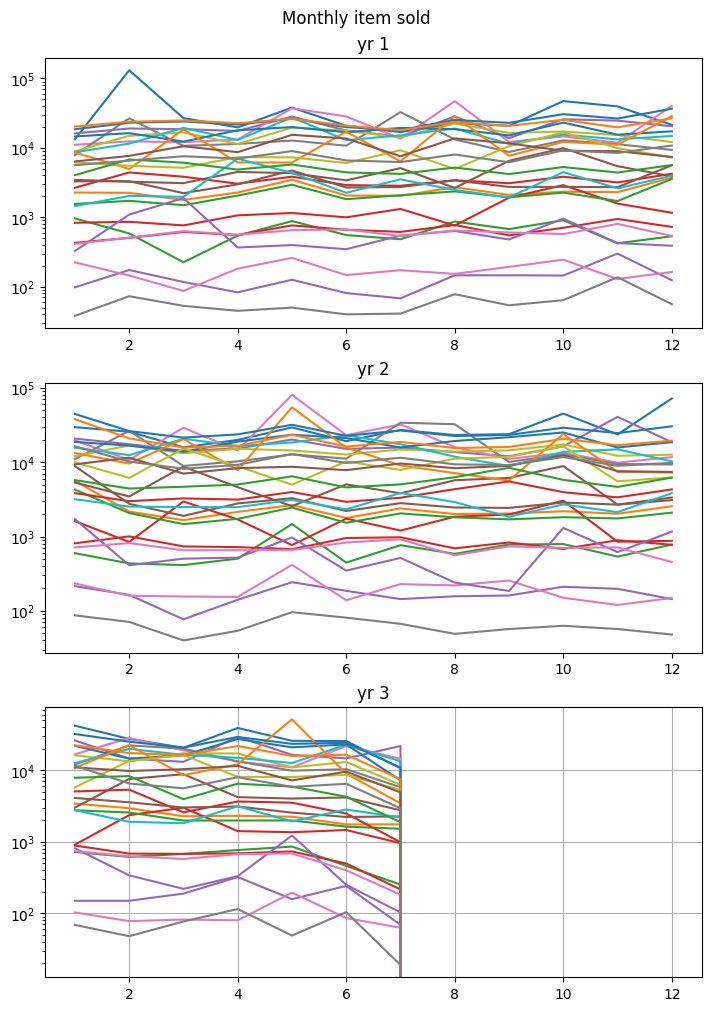

In [11]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(7, 10))

for key in item_week.keys():
    axs[0].plot(mts, item_week[key][0, :])
    axs[1].plot(mts, item_week[key][1, :])
    axs[2].plot(mts, item_week[key][2, :])

fig.suptitle('Monthly item sold')
axs[0].set_title('yr 1')
axs[1].set_title('yr 2')
axs[2].set_title('yr 3')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
plt.grid()
plt.show()

{219009: 964194.0, 217217: 75241.0, 300291: 20103.0, 398721: 46178.0, 222087: 601228.0, 245387: 150161.0, 223245: 650165.0, 219029: 450563.0, 216233: 450420.0, 222765: 478596.0, 217390: 567046.0, 223153: 455473.0, 217777: 64721.0, 378934: 109909.0, 673209: 4929.0, 219844: 98434.0, 327492: 5171.0, 545621: 1980.0, 245338: 276325.0, 547934: 88008.0, 216418: 786087.0, 216419: 628711.0, 320485: 166902.0, 546789: 21988.0, 600934: 19632.0, 216425: 291885.0, 679023: 19442.0, 300021: 265390.0}


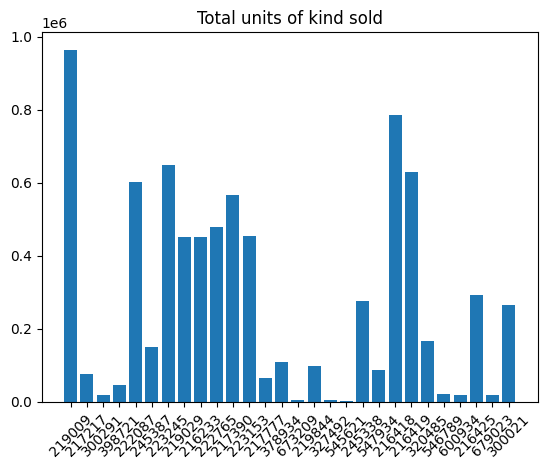

In [12]:
item_total = {}
for item in items:
    item_total[item] = 0
for key in item_week.keys():
    item_total[key] = np.sum(item_week[key])
print(item_total)

x = [str(x) for x in list(item_total.keys())]
y = list(item_total.values())
plt.bar(x, y)
plt.xticks(rotation=45)
plt.title('Total units of kind sold')
plt.show()

In [13]:
stores = [x[2] for x in d_unsh]
stores = list(set(stores))
store_week = {}
for store in stores:
    store_week[store] = np.zeros((3, 13, 32))

for row in d_unsh:
    year = int(row[1].split('/')[2]) - 11
    store_week[row[2]][year][int(row[1].split('/')[1])][int(row[1].split('/')[0])] += row[-1]

for key in store_week.keys():
    store_week[key] = np.sum(store_week[key], axis=2)[:, 1:]

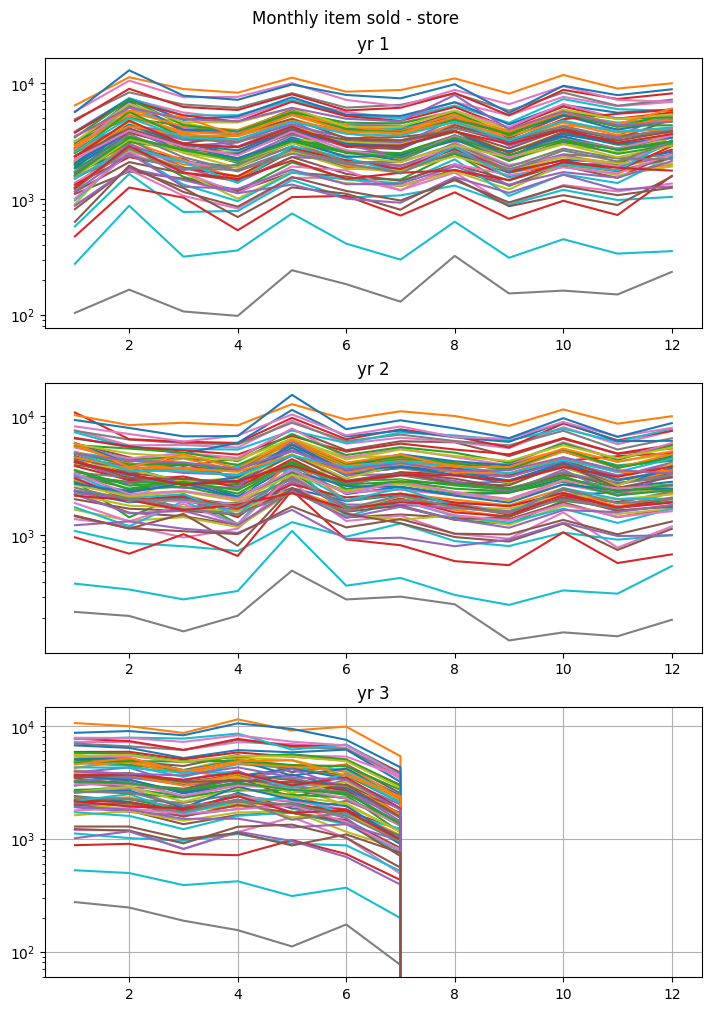

In [14]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(7, 10))

for key in store_week.keys():
    axs[0].plot(mts, store_week[key][0, :])
    axs[1].plot(mts, store_week[key][1, :])
    axs[2].plot(mts, store_week[key][2, :])

fig.suptitle('Monthly item sold - store')
axs[0].set_title('yr 1')
axs[1].set_title('yr 2')
axs[2].set_title('yr 3')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
plt.grid()
plt.show()